# Data preparation

In this module, we will start processing the dataset

In [1]:

import os
import pandas as pd

In [2]:
DATA_FOLDER = '../data/raw'

df_compas = pd.read_csv(os.path.join(DATA_FOLDER, 'compas-scores-two-years.csv'))

## First dataset reduction

We reduce the fields that contain administrative information, the fields that are 'replicated' in other fields (for example age and dob, here we only keep one) and fields that to not contain information that can contribute to prediction (for example description fields)

In [3]:
columns_to_keep = [ "sex", "age", "race", "juv_fel_count", "decile_score",
                   "juv_misd_count", "juv_other_count", "priors_count",
                   "days_b_screening_arrest", "c_jail_in", "c_jail_out",
                   "c_days_from_compas", "c_charge_degree", "v_decile_score",
                   "in_custody", "out_custody", "start", "end", "event", "two_year_recid" ]


df_reduced = df_compas[columns_to_keep].copy()



## Processing

We process fields that can be combined into one through difference

-  "c_jail_in",  "c_jail_out" will become c_jail_time
- "r_jail_in", "r_jail_out" will become r_jail_time
- "in_custody", "out_custody" will become custody_time
- "start", "end" will become end_start

In [4]:
# "c_jail_in",  "c_jail_out" will become c_jail_time
df_reduced['c_jail_in'] = pd.to_datetime(
    df_reduced['c_jail_in'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_reduced['c_jail_out'] = pd.to_datetime(
    df_reduced['c_jail_out'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_reduced['c_jail_time'] = abs((df_reduced['c_jail_out'] - df_reduced['c_jail_in']).dt.days)

# "in_custody", "out_custody" will become days_in_custody
df_reduced['in_custody'] = pd.to_datetime(
    df_reduced['in_custody'], format='%Y-%m-%d', errors='coerce')
df_reduced['out_custody'] = pd.to_datetime(
    df_reduced['out_custody'], format='%Y-%m-%d', errors='coerce')
df_reduced['days_in_custody'] = abs((df_reduced['out_custody'] - df_reduced['in_custody']).dt.days)

# "start", "end" will become end_start
df_reduced['end_start'] = abs((df_reduced['end'] - df_reduced['start']))

#remove all the columns that are not needed
df_reduced = df_reduced.drop(['c_jail_in', 'c_jail_out', 
                              'in_custody', 'out_custody',
                              'start', 'end'], axis=1)

# save the dataset
df_reduced.to_csv(os.path.join(DATA_FOLDER, 'df_reduced.csv'), index=False)


In [5]:
# gather information about the dataset - data types and missing values
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sex                      7214 non-null   object 
 1   age                      7214 non-null   int64  
 2   race                     7214 non-null   object 
 3   juv_fel_count            7214 non-null   int64  
 4   decile_score             7214 non-null   int64  
 5   juv_misd_count           7214 non-null   int64  
 6   juv_other_count          7214 non-null   int64  
 7   priors_count             7214 non-null   int64  
 8   days_b_screening_arrest  6907 non-null   float64
 9   c_days_from_compas       7192 non-null   float64
 10  c_charge_degree          7214 non-null   object 
 11  v_decile_score           7214 non-null   int64  
 12  event                    7214 non-null   int64  
 13  two_year_recid           7214 non-null   int64  
 14  c_jail_time             

In [6]:
# knn imputation of missing values in days_b_screening_arrest, c_jail_time, days_in_custody

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_reduced['days_b_screening_arrest'] = imputer.fit_transform(df_reduced[['days_b_screening_arrest']])
df_reduced['c_jail_time'] = imputer.fit_transform(df_reduced[['c_jail_time']])
df_reduced['days_in_custody'] = imputer.fit_transform(df_reduced[['days_in_custody']])
df_reduced['c_days_from_compas'] = imputer.fit_transform(df_reduced[['c_days_from_compas']])

df_reduced.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sex                      7214 non-null   object 
 1   age                      7214 non-null   int64  
 2   race                     7214 non-null   object 
 3   juv_fel_count            7214 non-null   int64  
 4   decile_score             7214 non-null   int64  
 5   juv_misd_count           7214 non-null   int64  
 6   juv_other_count          7214 non-null   int64  
 7   priors_count             7214 non-null   int64  
 8   days_b_screening_arrest  7214 non-null   float64
 9   c_days_from_compas       7214 non-null   float64
 10  c_charge_degree          7214 non-null   object 
 11  v_decile_score           7214 non-null   int64  
 12  event                    7214 non-null   int64  
 13  two_year_recid           7214 non-null   int64  
 14  c_jail_time             

In [7]:
# encoding of categorical features

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# transform feature 'sex'
df_reduced['sex'] = df_reduced['sex'].astype('category')
ohe_sex = pd.DataFrame(ohe.fit_transform(df_reduced[['sex']]).toarray(), columns=ohe.get_feature_names_out(['sex']))
df_reduced = pd.concat([df_reduced, ohe_sex], axis=1)

# transform feature 'race'
df_reduced['race'] = df_reduced['race'].astype('category')
ohe_race = pd.DataFrame(ohe.fit_transform(df_reduced[['race']]).toarray(), columns=ohe.get_feature_names_out(['race']))
df_reduced = pd.concat([df_reduced, ohe_race], axis=1)

# transform feature 'c_charge_degree'
df_reduced['c_charge_degree'] = df_reduced['c_charge_degree'].astype('category')
ohe_c_charge_degree = pd.DataFrame(ohe.fit_transform(df_reduced[['c_charge_degree']]).toarray(), columns=ohe.get_feature_names_out(['c_charge_degree']))
df_reduced = pd.concat([df_reduced, ohe_c_charge_degree], axis=1)


# remove original categorical features
df_reduced = df_reduced.drop(['sex', 'race', 'c_charge_degree', 'c_days_from_compas'], axis=1)

df_reduced.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      7214 non-null   int64  
 1   juv_fel_count            7214 non-null   int64  
 2   decile_score             7214 non-null   int64  
 3   juv_misd_count           7214 non-null   int64  
 4   juv_other_count          7214 non-null   int64  
 5   priors_count             7214 non-null   int64  
 6   days_b_screening_arrest  7214 non-null   float64
 7   v_decile_score           7214 non-null   int64  
 8   event                    7214 non-null   int64  
 9   two_year_recid           7214 non-null   int64  
 10  c_jail_time              7214 non-null   float64
 11  days_in_custody          7214 non-null   float64
 12  end_start                7214 non-null   int64  
 13  sex_Female               7214 non-null   float64
 14  sex_Male                

In [8]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      7214 non-null   int64  
 1   juv_fel_count            7214 non-null   int64  
 2   decile_score             7214 non-null   int64  
 3   juv_misd_count           7214 non-null   int64  
 4   juv_other_count          7214 non-null   int64  
 5   priors_count             7214 non-null   int64  
 6   days_b_screening_arrest  7214 non-null   float64
 7   v_decile_score           7214 non-null   int64  
 8   event                    7214 non-null   int64  
 9   two_year_recid           7214 non-null   int64  
 10  c_jail_time              7214 non-null   float64
 11  days_in_custody          7214 non-null   float64
 12  end_start                7214 non-null   int64  
 13  sex_Female               7214 non-null   float64
 14  sex_Male                

In [9]:
labels = ['two_year_recid', 'decile_score', 'v_decile_score']

df_features = df_reduced.copy().drop(labels, axis=1)

from sklearn.preprocessing import StandardScaler

features_scaled = pd.DataFrame(StandardScaler().fit(df_features).transform(df_features), columns=df_features.columns)

print(pd.DataFrame(features_scaled))


           age  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0     2.875313      -0.141855       -0.187414        -0.218065     -0.711240   
1    -0.068808      -0.141855       -0.187414        -0.218065     -0.711240   
2    -0.909985      -0.141855       -0.187414         1.775750      0.108063   
3    -0.994103      -0.141855        1.873571        -0.218065     -0.506414   
4     0.688252      -0.141855       -0.187414        -0.218065     -0.301588   
...        ...            ...             ...              ...           ...   
7209 -0.994103      -0.141855       -0.187414        -0.218065     -0.711240   
7210 -0.994103      -0.141855       -0.187414        -0.218065     -0.711240   
7211  1.865900      -0.141855       -0.187414        -0.218065     -0.711240   
7212 -0.152925      -0.141855       -0.187414        -0.218065     -0.096763   
7213 -0.994103      -0.141855       -0.187414        -0.218065     -0.301588   

      days_b_screening_arrest     event

In [10]:
scaled_features_no_race = features_scaled[[
'age',
'juv_fel_count',
'juv_misd_count',
'juv_other_count',
'priors_count',
'days_b_screening_arrest',
# 'event',
'c_jail_time',
'days_in_custody',
# 'end_start',
'sex_Female',
'sex_Male',
]]

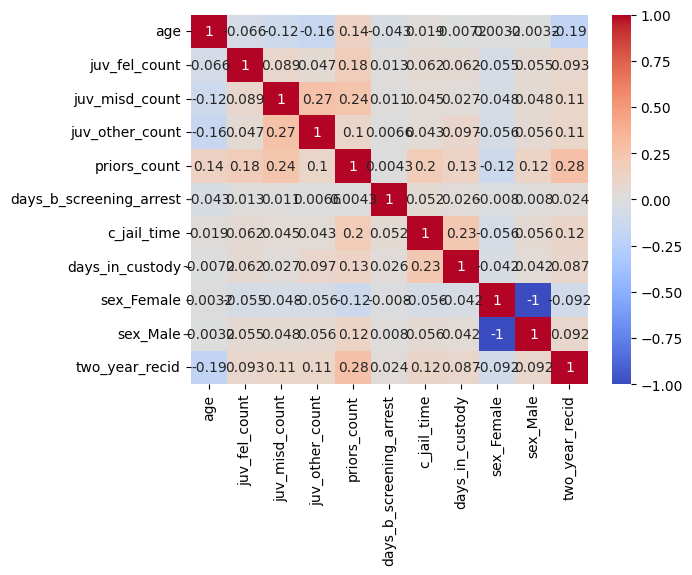

In [11]:
# do a correlation analysis of features_scaled and two_year_recid

import seaborn as sns
import matplotlib.pyplot as plt

join = pd.concat([scaled_features_no_race, df_reduced['two_year_recid']], axis=1)


sns.heatmap(join.corr(), annot=True, cmap='coolwarm')

plt.show()




## Some Tests on techniques

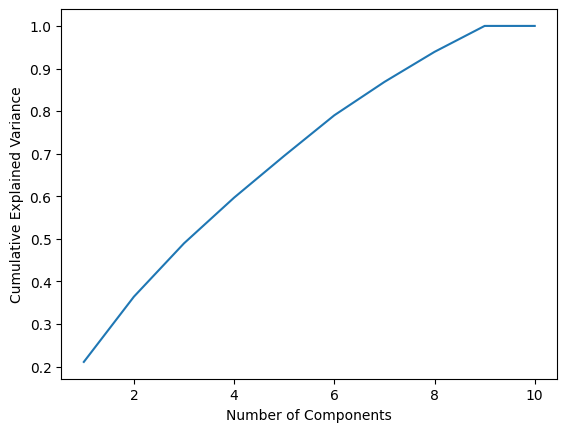

Number of components to retain 95.0% variance: 9
Component 1:
[ 0.01896475 -0.14304574 -0.17284938 -0.15791096 -0.25412275 -0.02590333
 -0.15845741 -0.13627817  0.63852785 -0.63852785]
Component 2:
[-0.13646628  0.27545901  0.45215248  0.3945328   0.39894147  0.07338587
  0.32234196  0.31618436  0.29747658 -0.29747658]
Component 3:
[ 0.59517526  0.02909312 -0.32305145 -0.41349629  0.3086014  -0.00406547
  0.41811988  0.30874343  0.0457192  -0.0457192 ]
Component 4:
[-0.40847837 -0.13299542 -0.2954423  -0.00369475 -0.37603533  0.54177644
  0.33359744  0.42491736 -0.02637752  0.02637752]
Component 5:
[ 0.00501419  0.56701523  0.01043223 -0.28273134  0.15700971  0.64315989
 -0.16107342 -0.36566521  0.0151717  -0.0151717 ]
Component 6:
[-0.34814659  0.66705862 -0.27974452 -0.18337448 -0.15172675 -0.51513182
  0.02433412  0.18156862  0.00110474 -0.00110474]
Component 7:
[-0.33252322 -0.16936202  0.15962387 -0.31361694  0.05846639 -0.14561438
  0.65055415 -0.53764815  0.00082079 -0.00082079]

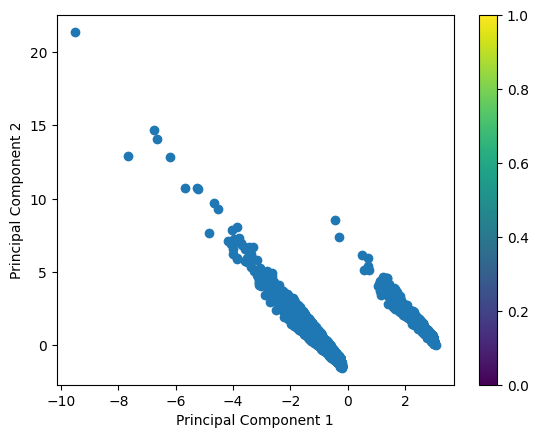

Number of components to retain 90.0% variance: 8
Top 2 features based on PCA loadings:
1. Feature 7, days_in_custody (Score: 2.6531)
2. Feature 3, juv_other_count (Score: 2.4019)
(7214, 8)


In [12]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(scaled_features_no_race)


import matplotlib.pyplot as plt
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


import numpy as np
threshold = 0.95  # Choose your threshold (e.g., 90% or 95%)
num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= threshold) + 1
print(f"Number of components to retain {threshold*100}% variance: {num_components}")


# Get the loadings for each component
loadings = pca.components_  # Shape: (n_components, n_features)
for i, component in enumerate(loadings[:num_components]):
    print(f"Component {i+1}:")
    print(component)
    
    
    
import matplotlib.pyplot as plt
plt.scatter(X_pca[:, 0], X_pca[:, 1])  # Plot PC1 vs PC2
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


# Step 3: Select the top principal components based on explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
threshold = 0.90  # Choose the threshold for explained variance
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Number of components to retain {threshold*100}% variance: {num_components}")

# Step 4: Get loadings for the selected components
loadings = pca.components_[:num_components]  # Shape: (num_components, n_features)

# Step 5: Compute feature importance by summing absolute values of loadings across selected components
feature_scores = np.sum(np.abs(loadings), axis=0)  # Shape: (n_features,)

# Step 6: Rank features and select the top n
n_top_features = 2  # Choose the number of top feaztures to select
top_feature_indices = np.argsort(feature_scores)[-n_top_features:][::-1]  # Indices of top features
top_features = [f"Feature {i}" for i in top_feature_indices]  # Replace with actual feature names if available

print(f"Top {n_top_features} features based on PCA loadings:")
for i, idx in enumerate(top_feature_indices):
    print(f"{i+1}. Feature {idx}, {scaled_features_no_race.columns[idx]} (Score: {feature_scores[idx]:.4f})")
    
    
    
X_pca_reduced = X_pca[:, :num_components]
print(X_pca_reduced.shape)


(7214, 8)
(7214,)
Accuracy: 0.65 (+/- 0.02)
Epoch 1, Loss: 0.6586972435491275
Epoch 2, Loss: 0.6288657214789264
Epoch 3, Loss: 0.6238743542833666
Epoch 4, Loss: 0.6225190996068769
Epoch 5, Loss: 0.618775144878742
Epoch 6, Loss: 0.6214148000014567
Epoch 7, Loss: 0.6184933281841531
Epoch 8, Loss: 0.6133664239824346
Epoch 9, Loss: 0.6114795457209106
Epoch 10, Loss: 0.6139344826208807
Epoch 11, Loss: 0.6104493812385914
Epoch 12, Loss: 0.6114477205329236
Epoch 13, Loss: 0.6126760370963442
Epoch 14, Loss: 0.6102641969919205
Epoch 15, Loss: 0.6073794966250394
Epoch 16, Loss: 0.6103307967428613
Epoch 17, Loss: 0.6057424133857795
Epoch 18, Loss: 0.6089054965867405
Epoch 19, Loss: 0.6065819906977425
Epoch 20, Loss: 0.6085052304299532
Epoch 21, Loss: 0.6061576693195158
Epoch 22, Loss: 0.6065591102944011
Epoch 23, Loss: 0.604606115185054
Epoch 24, Loss: 0.602970184741822
Epoch 25, Loss: 0.6053929509578553
Epoch 26, Loss: 0.6028826975189479
Epoch 27, Loss: 0.6045588848337663
Epoch 28, Loss: 0.60499

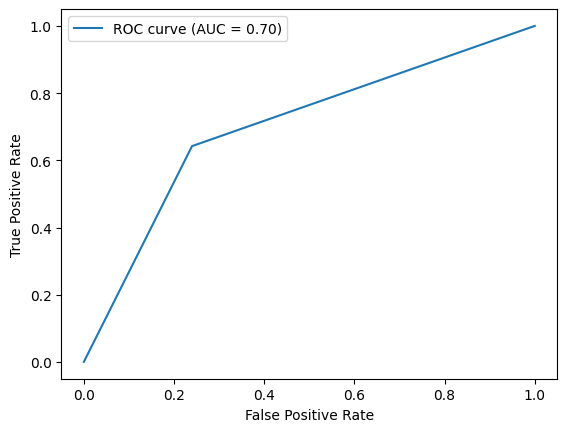

In [13]:
trainX = X_pca_reduced
trainy = df_reduced['two_year_recid']

print(trainX.shape)
print(trainy.shape)

# train a logistic regression model using k fold cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
model = LogisticRegression()
scores = cross_val_score(model, trainX, trainy, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# create a neural network model using k fold cross validation using pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

layers = [64, 32, 16]
model = nn.Sequential(
    nn.Linear(trainX.shape[1], layers[0]),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(layers[0], layers[1]),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(layers[1], layers[2]),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(layers[2], 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainX_tensor = torch.tensor(trainX, dtype=torch.float32)
trainy_tensor = torch.tensor(trainy, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(trainX_tensor, trainy_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# evaluate the model on the test set
with torch.no_grad():
    outputs = model(trainX_tensor)
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == trainy_tensor).float().mean()
    print(f"Accuracy: {accuracy.item() * 100:.2f}%")

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
    
    
fpr, tpr, thresholds = roc_curve(trainy, predicted)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()







In [14]:
# train a knn model using k fold cross validation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, trainX, trainy, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy: 0.66 (+/- 0.03)


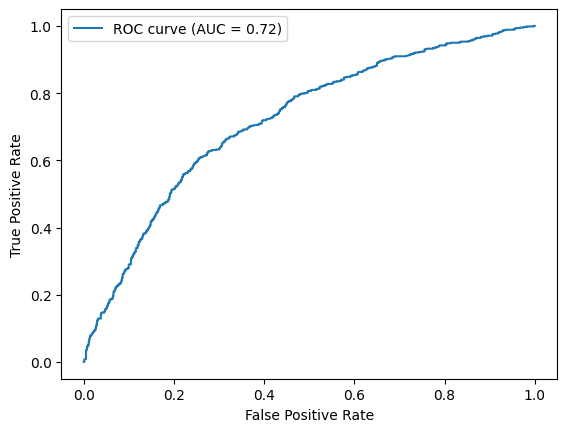

In [15]:
# plot an roc curve for the logistic regression

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(trainX, trainy, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()